In [9]:
! pip install maturin

In [10]:
 ! pip install underthesea

In [11]:
! pip install transformers==4.44.0 torch==2.3.0 datasets==2.19.0 scikit-learn==1.5.0 tqdm==4.66.1

  Using cached transformers-4.44.0-py3-none-any.whl.metadata (43 kB)
  Using cached torch-2.3.0-cp312-cp312-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached datasets-2.19.0-py3-none-any.whl.metadata (19 kB)
  Using cached scikit_learn-1.5.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached tokenizers-0.19.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-1

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import & Chuẩn bị dữ liệu

In [15]:
import pandas as pd
from underthesea import word_tokenize

# Đọc dữ liệu từ 3 file CSV
train_df = pd.read_csv("/feedback_train_clean.csv")
test_df  = pd.read_csv("/feedback_test_clean.csv")
valid_df = pd.read_csv("/feedback_valid_clean.csv")

# Map lại nhãn
train_df['sentiment'] = train_df['sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})
test_df['sentiment']  = test_df['sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})
valid_df['sentiment'] = valid_df['sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

# Tách từ tiếng Việt (PhoBERT yêu cầu tokenized input)
train_df["sentence_tok"] = train_df["sentence"].apply(lambda x: word_tokenize(str(x), format="text"))
test_df["sentence_tok"]  = test_df["sentence"].apply(lambda x: word_tokenize(str(x), format="text"))
valid_df["sentence_tok"] = valid_df["sentence"].apply(lambda x: word_tokenize(str(x), format="text"))

# Lấy dữ liệu và nhãn
train_texts, train_labels = train_df["sentence_tok"].tolist(), train_df["sentiment"].tolist()
test_texts,  test_labels  = test_df["sentence_tok"].tolist(),  test_df["sentiment"].tolist()
valid_texts, valid_labels = valid_df["sentence_tok"].tolist(), valid_df["sentiment"].tolist()

print("✅ Training samples:", len(train_texts))
print("✅ Validation samples:", len(valid_texts))
print("✅ Test samples:", len(test_texts))


✅ Training samples: 11426
✅ Validation samples: 1583
✅ Test samples: 3166


Import và chuẩn bị tokenizer (PhoBERT)

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Dùng PhoBERT
MODEL_NAME = "vinai/phobert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Hàm encode câu
def encode_texts(texts, tokenizer, max_len=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

print("✅ PhoBERT tokenizer loaded")


✅ PhoBERT tokenizer loaded


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tạo Dataset class cho PyTorch

In [17]:
class FeedbackDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, label2id, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.label2id[self.labels[idx]]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Map nhãn sang số
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

train_dataset = FeedbackDataset(train_texts, train_labels, tokenizer, label2id)
valid_dataset = FeedbackDataset(valid_texts, valid_labels, tokenizer, label2id)
test_dataset  = FeedbackDataset(test_texts,  test_labels,  tokenizer, label2id)

print("✅ Dataset ready")


✅ Dataset ready


PhoBERT Fine-tuning

In [18]:
from transformers import AutoModelForSequenceClassification

num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("✅ Model loaded on:", device)


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded on: cuda


Huấn luyện mô hình

Epoch 1/3: 100%|██████████| 715/715 [04:23<00:00,  2.71it/s, loss=0.00249]



📊 Epoch 1/3
   ✅ Train loss: 0.0532, acc: 0.9848
   🧪 Valid loss: 0.2460, acc: 0.9457, F1: 0.9420


Epoch 2/3: 100%|██████████| 715/715 [04:22<00:00,  2.72it/s, loss=0.00147]



📊 Epoch 2/3
   ✅ Train loss: 0.0380, acc: 0.9889
   🧪 Valid loss: 0.2771, acc: 0.9444, F1: 0.9416


Epoch 3/3: 100%|██████████| 715/715 [04:22<00:00,  2.72it/s, loss=0.0134]



📊 Epoch 3/3
   ✅ Train loss: 0.0409, acc: 0.9873
   🧪 Valid loss: 0.2624, acc: 0.9482, F1: 0.9480


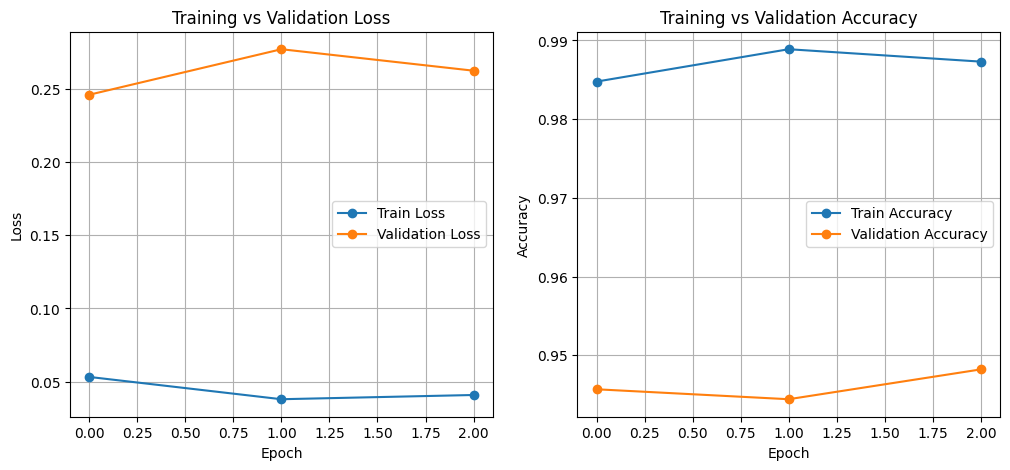

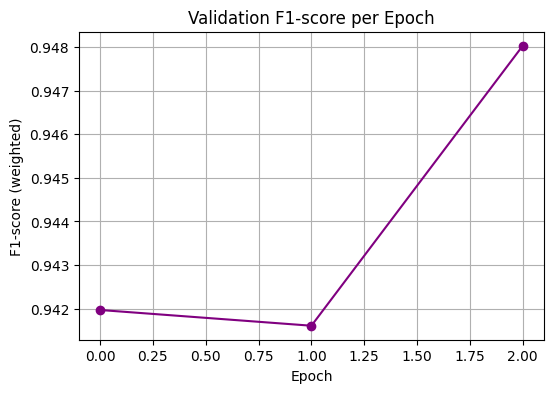


📈 Final Validation Report:
              precision    recall  f1-score   support

    negative       0.95      0.96      0.96       705
     neutral       0.69      0.67      0.68        73
    positive       0.97      0.96      0.96       805

    accuracy                           0.95      1583
   macro avg       0.87      0.86      0.87      1583
weighted avg       0.95      0.95      0.95      1583



In [28]:
# 🏋️‍♂️ Huấn luyện mô hình + Vẽ biểu đồ Train/Valid Loss & Accuracy

import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

optimizer = AdamW(model.parameters(), lr=LR)
loss_fn = CrossEntropyLoss()

train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
valid_f1_scores = []


for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    total_loss = 0
    total_preds, total_trues = [], []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        total_preds.extend(preds.cpu().numpy())
        total_trues.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()
        pbar.set_postfix({"loss": loss.item()})

    avg_train_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(total_trues, total_preds)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ---- VALID ----
    model.eval()
    val_loss = 0
    val_preds, val_trues = [], []

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            val_preds.extend(predictions.cpu().numpy())
            val_trues.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader)
    val_acc = accuracy_score(val_trues, val_preds)
    val_f1 = f1_score(val_trues, val_preds, average="weighted")

    valid_losses.append(avg_val_loss)
    valid_accuracies.append(val_acc)
    valid_f1_scores.append(val_f1)

    print(f"\n📊 Epoch {epoch+1}/{EPOCHS}")
    print(f"   ✅ Train loss: {avg_train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"   🧪 Valid loss: {avg_val_loss:.4f}, acc: {val_acc:.4f}, F1: {val_f1:.4f}")

# ---- Vẽ biểu đồ ----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(valid_losses, label='Validation Loss', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(valid_accuracies, label='Validation Accuracy', marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ---- F1-score biểu đồ ----
plt.figure(figsize=(6,4))
plt.plot(valid_f1_scores, color='purple', marker='o')
plt.title("Validation F1-score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1-score (weighted)")
plt.grid(True)
plt.show()

# ---- Báo cáo cuối cùng ----
print("\n📈 Final Validation Report:")
print(classification_report(val_trues, val_preds, target_names=label2id.keys()))


Đánh giá mô hình trên tập Validation và lập biểu đồ so sánh

Evaluating: 100%|██████████| 99/99 [00:11<00:00,  8.87it/s]



✅ Validation Accuracy: 0.9482

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.96      0.96       705
     neutral       0.69      0.67      0.68        73
    positive       0.97      0.96      0.96       805

    accuracy                           0.95      1583
   macro avg       0.87      0.86      0.87      1583
weighted avg       0.95      0.95      0.95      1583



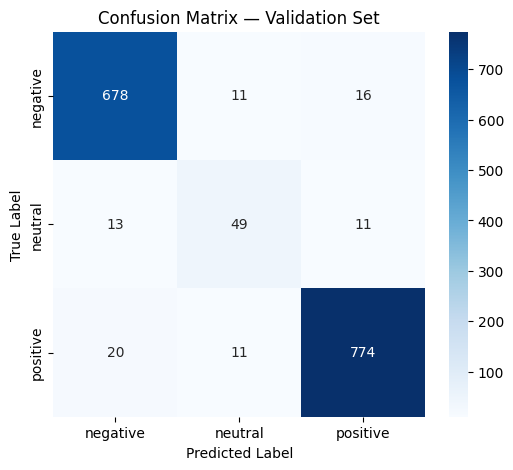


🔍 Một vài ví dụ dự đoán sai:


,text,true,pred
28,ôn_tập kỹ trước khi thi hoặc trong lúc giảng_d...,negative,positive
30,"thầy cho tự tìm_hiểu , và tự tìm_hiểu khác với...",neutral,positive
51,cô rất nghiêm .,negative,positive
59,ngoài_ra cung_cấp một_vài thông_tin bổ_sung về...,positive,negative
113,chủ_yếu dựa vào năng_lực tự học của sinh_viên .,negative,neutral
117,sự nhiệt_tình .,neutral,positive
127,cẩn_thận .,neutral,positive
161,"thầy khá hiền , ít nói .",negative,positive
172,thầy tiếp_tục giảng_bài .,neutral,negative
175,"thầy ít có giảng về bài_tập , chỉ cho sinh_viê...",positive,negative


In [29]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Đưa model về eval
model.eval()
preds, trues = [], []
texts = []  # để phân tích lỗi

with torch.no_grad():
    for batch in tqdm(valid_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        preds.extend(predictions.cpu().numpy())
        trues.extend(labels.cpu().numpy())

# === Đánh giá định lượng ===
acc = accuracy_score(trues, preds)
print(f"\n✅ Validation Accuracy: {acc:.4f}\n")
print("📊 Classification Report:")
print(classification_report(trues, preds, target_names=list(label2id.keys())))

# === Ma trận nhầm lẫn ===
cm = confusion_matrix(trues, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label2id.keys()),
            yticklabels=list(label2id.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Validation Set")
plt.show()

# === Phân tích lỗi (in ra vài ví dụ dự đoán sai) ===
wrong_df = pd.DataFrame({
    "text": valid_texts[:len(trues)],
    "true": [list(label2id.keys())[i] for i in trues],
    "pred": [list(label2id.keys())[i] for i in preds]
})

wrong_samples = wrong_df[wrong_df["true"] != wrong_df["pred"]].head(10)
if not wrong_samples.empty:
    print("\n🔍 Một vài ví dụ dự đoán sai:")
    display(wrong_samples)
else:
    print("🎯 Mô hình dự đoán chính xác tất cả mẫu validation!")


In [30]:
model.eval()
preds, trues = [], []

with torch.no_grad():
    for batch in tqdm(valid_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        preds.extend(predictions.cpu().numpy())
        trues.extend(labels.cpu().numpy())

print("✅ Validation Accuracy:", accuracy_score(trues, preds))
print(classification_report(trues, preds, target_names=label2id.keys()))


Evaluating: 100%|██████████| 99/99 [00:11<00:00,  8.61it/s]

✅ Validation Accuracy: 0.9481996209728364
              precision    recall  f1-score   support

    negative       0.95      0.96      0.96       705
     neutral       0.69      0.67      0.68        73
    positive       0.97      0.96      0.96       805

    accuracy                           0.95      1583
   macro avg       0.87      0.86      0.87      1583
weighted avg       0.95      0.95      0.95      1583



Lưu mô hình

In [26]:
import shutil
from google.colab import files

SAVE_DIR = "phobert_sentiment_model"

# Lưu mô hình và tokenizer
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print("✅ Model saved to:", SAVE_DIR)

# Nén thư mục lại thành file ZIP
zip_path = SAVE_DIR + ".zip"
shutil.make_archive(SAVE_DIR, 'zip', SAVE_DIR)
print("📦 Model compressed:", zip_path)

# Cho phép tải file zip về máy
files.download(zip_path)


✅ Model saved to: phobert_sentiment_model
📦 Model compressed: phobert_sentiment_model.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>